# Modeling with genetic algorithm feature selection (next year)

## Install packages

In [1]:
# Set current working directory
import os
path = "/Users/fleurroijen/Library/Mobile Documents/com~apple~CloudDocs/Documents/University/Tilburg University MSc/TiU Spring 24:25/Master Thesis : Data Science in Action/Predicting-Tax-Avoidance"
os.chdir(path)

In [2]:
# Load necessary packages
import warnings
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# Visualization
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from pandas.plotting import register_matplotlib_converters

# Optimization
import optuna
from optuna import Trial, visualization

# Scikit-learn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score
)

# XGBoost
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Loading the datasets
X_train_full = pd.read_csv('X_train_full.csv', index_col=0)
X_train = pd.read_csv('X_train.csv', index_col=0)
X_val = pd.read_csv('X_val.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
y_train_full = pd.read_csv('y_train_full.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_val = pd.read_csv('y_val.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [4]:
# Checking the datasets
print(X_train_full.shape)
print(y_train_full.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(43522, 77)
(43522, 1)
(34818, 77)
(34818, 1)
(8704, 77)
(8704, 1)
(7445, 77)
(7445, 1)


In [5]:
if isinstance(y_train_full, pd.DataFrame) and y_train_full.shape[1] == 1:
    y_train_full = y_train_full.squeeze()

In [6]:
if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
    y_train = y_train.squeeze()
y_train = np.asarray(y_train)

In [7]:
if not isinstance(y_train_full, pd.Series):
    y_train_full = pd.Series(y_train_full, name="tax_avoidance_ind")

In [8]:
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train, name="tax_avoidance_ind")

## Feature selection with genetic algorithm

In [9]:
# Code inspired by:
# https://medium.com/@ela.markovic/feature-selection-using-genetic-algorithm-complete-beginner-friendly-guide-198496393728

In [ ]:
# Generating the initial population
def generate_random_individuals(pop_size, num_features, min_features, max_features, fyear_sin_index, fyear_cos_index):
    individuals = np.zeros((pop_size, num_features))
    for i in range(pop_size):
        num_ones = np.random.randint(min_features, max_features+1)
        ones_indices = np.random.choice(num_features, num_ones, replace=False)
        individuals[i, ones_indices] = 1

        if individuals[i, fyear_sin_index] == 1:
            individuals[i, fyear_cos_index] = 1
        if individuals[i, fyear_cos_index] == 1:
            individuals[i, fyear_sin_index] = 1
            
    return individuals

In [11]:
# Training model and returning F1-score
def train_model(X_train, X_val, y_train, y_val, feature_names):
    X_train_sel = X_train.loc[:, feature_names]
    X_val_sel = X_val.loc[:, feature_names]
    mdl = RandomForestClassifier(random_state=123)
    mdl.fit(X_train_sel, y_train)
    y_hat = mdl.predict(X_val_sel)
    return f1_score(y_val, y_hat)

In [12]:
# Choosing parents
def choose_parents(population, f1, elite_percent):
    elite_num = int(round(((elite_percent * population.shape[0]) // 2) * 2))
    ind_ac = np.argsort(-f1)
    elite_population = population[ind_ac[:elite_num], :]

    weight_norm = f1 / f1.sum()
    weight_comu = weight_norm.cumsum()
    num_parents_wo_elite = population.shape[0] - elite_num
    parents_wo_elite = np.empty([num_parents_wo_elite, population.shape[1]])
    
    for count in range(num_parents_wo_elite):
        rand_num = np.random.uniform(0, weight_comu[-1])
        index = np.searchsorted(weight_comu, rand_num)
        parents_wo_elite[count, :] = population[index, :]
    
    return np.concatenate((elite_population, parents_wo_elite), axis=0)

In [ ]:
# Crossover and mutation
def one_point_crossover(parents, elite_percent, mutation_probability, min_features, max_features, fyear_sin_index, fyear_cos_index):
    elite_num = int(round(((elite_percent * parents.shape[0]) // 2) * 2))
    children = np.zeros_like(parents)
    children[:elite_num, :] = parents[:elite_num, :]

    for i in range((parents.shape[0] - elite_num) // 2):
        n = 2 * i + elite_num
        p1, p2 = parents[n], parents[n + 1]
        cut = np.random.randint(1, parents.shape[1] - 1)
        children[n] = np.concatenate([p1[:cut], p2[cut:]])
        children[n + 1] = np.concatenate([p2[:cut], p1[cut:]])

    # Repair to maintain feature constraints
    for i in range(children.shape[0]):
        ones = np.sum(children[i])
        if ones > max_features:
            idx = np.where(children[i] == 1)[0]
            children[i, np.random.choice(idx, int(ones - max_features), replace=False)] = 0
        elif ones < min_features:
            idx = np.where(children[i] == 0)[0]
            children[i, np.random.choice(idx, int(min_features - ones), replace=False)] = 1

        if children[i, fyear_sin_index] == 1:
            children[i, fyear_cos_index] = 1
        if children[i, fyear_cos_index] == 1:
            children[i, fyear_sin_index] = 1

    # Mutation
    total_mut = int(children.size * mutation_probability)
    for _ in range(total_mut):
        r, c = np.random.randint(children.shape[0]), np.random.randint(children.shape[1])
        current_sum = np.sum(children[r])
        if children[r, c] == 0 and current_sum < max_features:
            children[r, c] = 1
        elif children[r, c] == 1 and current_sum > min_features:
            children[r, c] = 0

        if children[i, fyear_sin_index] == 1:
            children[i, fyear_cos_index] = 1
        if children[i, fyear_cos_index] == 1:
            children[i, fyear_sin_index] = 1
            
    return children

In [ ]:
# Setting hyperparameters
min_features = 2
max_features = 37
population_size = 20
max_iterations = 20
elite_percent = 0.4
mutation_probability = 0.3
early_stopping_rounds = 10
fyear_sin_index = feature_names.get_loc('fyear_sin')
fyear_cos_index = feature_names.get_loc('fyear_cos')

In [15]:
# Getting data dimensions
feature_names = X_train.columns

In [ ]:
# Generation 0
population = generate_random_individuals(population_size, len(feature_names), min_features, max_features, fyear_sin_index, fyear_cos_index)

# Parallel evaluation
f1 = Parallel(n_jobs=-1)(delayed(train_model)(
    X_train, X_val, y_train, y_val, feature_names[population[i] == 1]
) for i in range(population_size))
f1 = np.array(f1)

gen = 0
best_f1_i = np.zeros(max_iterations)
best_f1_i[gen] = f1.max()
best_f1 = best_f1_i[gen]
no_improvement_count = 0

# GA main loop
while gen < max_iterations - 1:
    print(f'Begin iteration {gen + 2}/{max_iterations}')
    gen += 1

    parents = choose_parents(population, f1, elite_percent)
    population = one_point_crossover(parents, elite_percent, mutation_probability, min_features, max_features, fyear_sin_index, fyear_cos_index)

    # Parallel evaluation
    f1 = Parallel(n_jobs=-1)(delayed(train_model)(
        X_train, X_val, y_train, y_val, feature_names[population[i] == 1]
    ) for i in range(population_size))
    f1 = np.array(f1)

    best_f1_i[gen] = f1.max()

    if best_f1_i[gen] > best_f1:
        best_f1 = best_f1_i[gen]
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        print(f"No improvement for {no_improvement_count} generations.")

    if no_improvement_count >= early_stopping_rounds:
        print(f"Early stopping at generation {gen + 1}.")
        break

# Displaying results
best_index = np.argmax(f1)
best_features = population[best_index]
selected_indices = np.where(best_features == 1)[0]
print("Best features selected (indices):", selected_indices)
print("Best F1 score achieved:", best_f1)

Begin iteration 2/20
Begin iteration 3/20
No improvement for 1 generations.
Begin iteration 4/20
No improvement for 2 generations.
Begin iteration 5/20
No improvement for 3 generations.
Begin iteration 6/20
Begin iteration 7/20
No improvement for 1 generations.
Begin iteration 8/20
No improvement for 2 generations.
Begin iteration 9/20
Begin iteration 10/20
No improvement for 1 generations.
Begin iteration 11/20
No improvement for 2 generations.
Begin iteration 12/20
No improvement for 3 generations.
Begin iteration 13/20
Begin iteration 14/20
No improvement for 1 generations.
Begin iteration 15/20
No improvement for 2 generations.
Begin iteration 16/20
No improvement for 3 generations.
Begin iteration 17/20
No improvement for 4 generations.
Begin iteration 18/20
No improvement for 5 generations.
Begin iteration 19/20
No improvement for 6 generations.
Begin iteration 20/20
No improvement for 7 generations.
Best features selected (indices): [ 0  3  4  5  9 11 12 13 14 18 19 20 21 26 28 

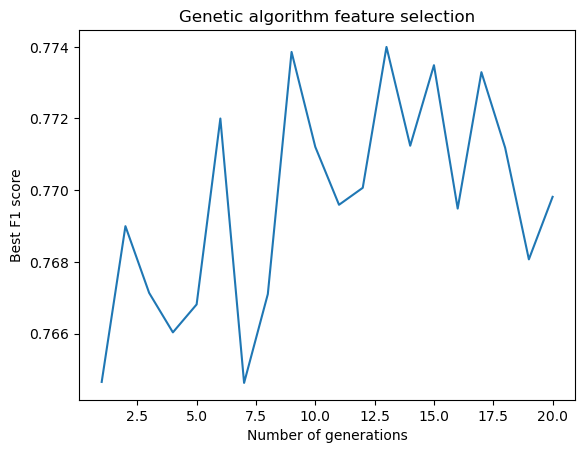

In [17]:
# Plotting the results
plt.plot(range(1, max_iterations + 1), best_f1_i)
plt.xlabel('Number of generations')
plt.ylabel('Best F1 score')
plt.title('Genetic algorithm feature selection')
plt.show()

In [18]:
# Creating new dataset with selected features
best_features_names = feature_names[best_features==1]
X_train_GA_full = X_train_full[best_features_names]
X_train_GA = X_train[best_features_names]
X_val_GA = X_val[best_features_names]
X_test_GA = X_test[best_features_names]

# Summarizing the results
print("Selected features from GA:", list(best_features_names))
print("Shape of reduced full training data (X_train_GA_full):", X_train_GA_full.shape)
print("Shape of reduced training data (X_train_GA):", X_train_GA.shape)
print("Shape of reduced validation data (X_val_GA):", X_val_GA.shape)
print("Shape of reduced test data (X_test_GA):", X_test_GA.shape)

Selected features from GA: ['act_lag1', 'apo_lag1', 'at_lag1', 'capx_lag1', 'cogs_lag1', 'dlc_lag1', 'dltt_lag1', 'dp_lag1', 'dpc_lag1', 'gdwl_lag1', 'ib_lag1', 'icapt_lag1', 'intan_lag1', 'lo_lag1', 'lt_lag1', 'oancf_lag1', 'oibdp_lag1', 'pi_lag1', 'recco_lag1', 'rectr_lag1', 'txc_lag1', 'txdb_lag1', 'txdi_lag1', 'txditc_lag1', 'txo_lag1', 'txp_lag1', 'xint_lag1', 'xopr_lag1', 'etr_lag1', 'region_South', 'industry_Information', 'industry_Leisure', 'industry_Social', 'industry_Trade', 'industry_Transport', 'fyear_sin', 'fyear_cos']
Shape of reduced full training data (X_train_GA_full): (43522, 37)
Shape of reduced training data (X_train_GA): (34818, 37)
Shape of reduced validation data (X_val_GA): (8704, 37)
Shape of reduced test data (X_test_GA): (7445, 37)


## Modeling

### Baseline logistic regression (no hyperparameter tuning)

In [19]:
# Instantiating the classifier
model_lr = LogisticRegression(random_state=123)

# Fitting the model
model_lr.fit(X_train_GA_full, y_train_full)

LogisticRegression(random_state=123)

In [20]:
# Making predictions (test set)
y_pred_lr = model_lr.predict(X_test_GA)
y_proba_lr = model_lr.predict_proba(X_test_GA)
y_proba_lr_pos = y_proba_lr[:, 1]

In [21]:
# Making predictions (train set)
y_pred_lr_train = model_lr.predict(X_train_GA_full)
y_proba_lr_train = model_lr.predict_proba(X_train_GA_full)
y_proba_lr_train_pos = y_proba_lr_train[:, 1]

#### Evaluating baseline logistic regression

In [22]:
# Creating a function for the evaluation metrics
def evaluate(y_true, y_pred, y_proba, classifier):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"Evaluation metrics for {classifier}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

In [23]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_lr, y_proba_lr_pos, "baseline logistic regression with GA feature selection")

Evaluation metrics for baseline logistic regression with GA feature selection:
Accuracy: 0.6462
Precision: 0.4141
Recall: 0.7561
F1 Score: 0.5351
AUC-ROC: 0.7396
Precision-Recall AUC: 0.4742


In [24]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_lr_train, y_proba_lr_train_pos, "baseline logistic regression with GA feature selection (train set)")

Evaluation metrics for baseline logistic regression with GA feature selection (train set):
Accuracy: 0.6851
Precision: 0.6588
Recall: 0.7679
F1 Score: 0.7092
AUC-ROC: 0.7414
Precision-Recall AUC: 0.6991


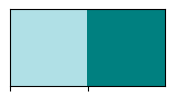

In [25]:
# Defining a smooth fading color gradient
color_codes = ["powderblue", "teal"]
fading_cmap = LinearSegmentedColormap.from_list("fading_blues", color_codes)

# Displaying the fading color palette (optional)
sns.palplot(sns.color_palette(color_codes))

In [26]:
# Code inspired by:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
def plot_confusion_matrix(y_true, y_pred, model_name):
    class_names = ['yes', 'no']

    # Computing and normalizing the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(matrix, annot=True, fmt=".2f", cmap=fading_cmap, 
                     xticklabels=class_names, yticklabels=class_names,
                     linewidths=0.2, vmin=0, vmax=1)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.tight_layout()
    plt.show()

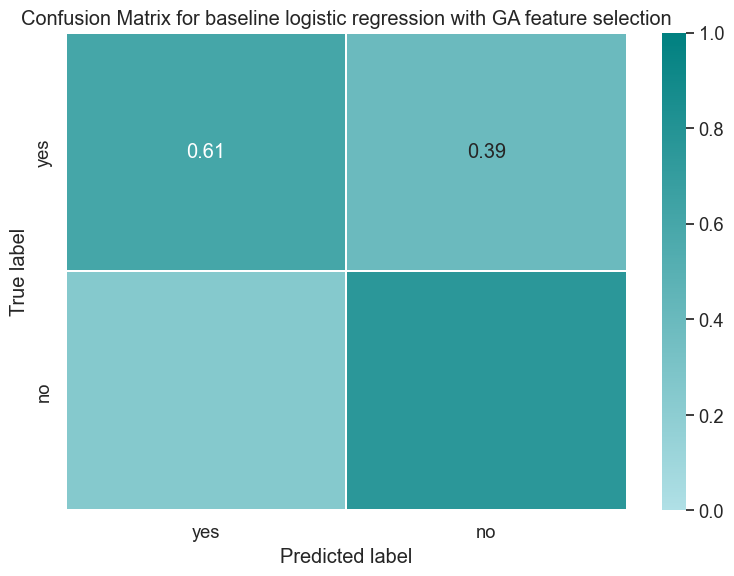

In [27]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_lr, "baseline logistic regression with GA feature selection")

In [28]:
# Printing the classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.61      0.71      5440
           1       0.41      0.76      0.54      2005

    accuracy                           0.65      7445
   macro avg       0.64      0.68      0.62      7445
weighted avg       0.75      0.65      0.67      7445



### Logistic regression

In [29]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67

# Defining an objective function to be maximized using pre-defined train/val splits
def objective_lr(trial):
    # Define all valid (solver, penalty) combos explicitly
    solver_penalty_combo = trial.suggest_categorical(
        'solver_penalty',
        [
            ('lbfgs', 'l2'),               # lbfgs only supports l2
            ('liblinear', 'l1'),
            ('liblinear', 'l2'),
            ('saga', 'l1'),
            ('saga', 'l2'),
            ('saga', 'elasticnet'),
        ]
    )
    
    solver, penalty = solver_penalty_combo
    
    C = trial.suggest_float("C", 1e-4, 1e4, log=True)
    tol = trial.suggest_float("tol", 1e-4, 1e-1, log=True)
    verbose = trial.suggest_int("verbose", 0, 1)
    
    params_lr = dict(solver=solver, penalty=penalty, C=C, tol=tol, verbose=verbose)
    
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        params_lr["l1_ratio"] = l1_ratio
    
    model_lr = LogisticRegression(**params_lr, random_state=123, n_jobs=-1)
    
    model_lr.fit(X_train_GA, y_train)
    
    y_pred = model_lr.predict(X_val_GA)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_lr.trials))
print('Best parameters:', study_lr.best_trial.params)
print('Best F1 score:', study_lr.best_value)

[I 2025-05-16 19:06:28,220] A new study created in memory with name: no-name-09290957-3456-4603-bc01-28cf5a0a825a


Epoch 1, change: 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float

Epoch 2, change: 0.42145711
Epoch 3, change: 0.26436528
Epoch 1, change: 1
Epoch 4, change: 0.19685364
Epoch 2, change: 0.38669963


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 3, change: 0.23136303


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     36     48      1     0     0   3.619D-04   6.062D-01
  F =  0.60622429960686008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 5, change: 0.15761948
Epoch 1, change: 1
Epoch 2, change: 0.42348476
Epoch 6, change: 0.13231967
Epoch 3, change: 0.26618104
Epoch 4, change: 0.17119565
Epoch 4, change: 0.19819432
Epoch 5, change: 0.13767375
Epoch 7, change: 0.1143429
Epoch 5, change: 0.15861625


[I 2025-05-16 19:06:29,003] Trial 5 finished with value: 0.6550572036043333 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 191.2708107955194, 'tol': 0.08835283595353696, 'verbose': 0}. Best is trial 4 with value: 0.7174462705436156.


Epoch 8, change: 0.10067949
Epoch 6, change: 0.13303183
Epoch 6, change: 0.11736882
Epoch 7, change: 0.11484324
Epoch 9, change: 0.089694057
Epoch 7, change: 0.10326341
Epoch 8, change: 0.10103242
Epoch 8, change: 0.09239939


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 9, change: 0.089933407
Epoch 10, change: 0.080751642
Epoch 9, change: 0.083584798
Epoch 11, change: 0.073281202
Epoch 10, change: 0.080913869
Epoch 12, change: 0.067050273
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
Epoch 10, change: 0.07616702
Epoch 11, change: 0.073381942


 This problem is unconstrained.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Epoch 11, change: 0.069932957
Epoch 13, change: 0.061689586
Epoch 12, change: 0.067105313

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     26     32      1     0     0   1.245D-03   6.070D-01
  F =  0.60698424348069246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 13, change: 0.061709938
Epoch 14, change: 0.057061346
Epoch 12, change: 0.064634049
Epoch 14, change: 0.057052922
Epoch 15, change: 0.053027338
Epoch 15, change: 0.052995179
Epoch 13, change: 0.060009075
Epoch 16, change: 0.049478036
Epoch 16, change: 0.049428985
Epoch 14, change: 0.05598917
Epoch 17, change: 0.046280011
Epoc

[I 2025-05-16 19:06:30,237] Trial 6 finished with value: 0.7167630057803468 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.08117091235802995, 'tol': 0.0005299782176055541, 'verbose': 1}. Best is trial 4 with value: 0.7174462705436156.


Epoch 27, change: 0.027680388
Epoch 29, change: 0.025386622
Epoch 30, change: 0.024419194
Epoch 24, change: 0.032803437
Epoch 28, change: 0.026553625
Epoch 31, change: 0.023517889
Epoch 25, change: 0.031441242
Epoch 29, change: 0.025511731
Epoch 32, change: 0.022666236
Epoch 26, change: 0.03019324
Epoch 33, change: 0.021878589
Epoch 30, change: 0.024545737
Epoch 34, change: 0.021134808


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 27, change: 0.029028755
Epoch 31, change: 0.023645591
Epoch 35, change: 0.020446931
Epoch 32, change: 0.022794231
Epoch 28, change: 0.027941453
Epoch 36, change: 0.019792186
Epoch 37, change: 0.019173699
Epoch 29, change: 0.026927503
Epoch 33, change: 0.022007696
Epoch 1, change: 1
Epoch 2, change: 0.40759285
Epoch 30, change: 0.025989314


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 38, change: 0.018585156
Epoch 34, change: 0.021263965
Epoch 39, change: 0.018041262
Epoch 3, change: 0.25161614
Epoch 4, change: 0.18719948
Epoch 31, change: 0.025114491
Epoch 35, change: 0.020576555
Epoch 40, change: 0.017516905
Epoch 5, change: 0.15027744
Epoch 32, change: 0.024270546
Epoch 36, change: 0.019922046
Epoch 41, change: 0.017030475
Epoch 33, change: 0.023505954
Epoch 37, change: 0.019303288
Epoch 6, change: 0.12693455
Epoch 42, change: 0.016555334
Epoch 7, change: 0.11043321
Epoch 38, change: 0.01871491
Epoch 34, change: 0.022765257
Epoch 43, change: 0.016116384
Epoch 35, change: 0.022082066
Epoch 44, change: 0.015695581
Epoch 45, change: 0.015300028
Epoch 8, change: 0.097816102
Epoch 39, change: 0.018171118
Epoch 36, change: 0.021428279
Epoch 46, change: 0.014915763
Epoch 9, change: 0.087638182
Epoch 40, change: 0.017646542


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished
[I 2025-05-16 19:06:31,838] Trial 12 finished with value: 0.6520094079149197 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 0.0007281785597082371, 'tol': 0.07788540985795753, 'verbose': 1}. Best is trial 4 with value: 0.7174462705436156.
[I 2025-05-16 19:06:31,875] Trial 11 finished with value: 0.7182401852436585 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.3728331530979896, 'tol': 0.00043276704385228663, 'verbose': 0}. Best is trial 11 with value: 0.7182401852436585.


Epoch 47, change: 0.014555386
Epoch 37, change: 0.020794174
Epoch 10, change: 0.07925071
Epoch 41, change: 0.017159977
Epoch 38, change: 0.020204149
convergence after 11 epochs took 1 seconds
Epoch 48, change: 0.014208929


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 42, change: 0.016684727
Epoch 39, change: 0.019655057
Epoch 49, change: 0.013875825
Epoch 43, change: 0.016245622
Epoch 1, change: 1
Epoch 40, change: 0.019113042
Epoch 50, change: 0.01355991
Epoch 44, change: 0.015824705
Epoch 2, change: 0.42351566
Epoch 51, change: 0.013259415
Epoch 41, change: 0.018613894
Epoch 45, change: 0.01542888
Epoch 52, change: 0.012970671
Epoch 3, change: 0.26622064
Epoch 42, change: 0.018118495
Epoch 53, change: 0.012695172
Epoch 46, change: 0.015044229
Epoch 4, change: 0.1982367
Epoch 43, change: 0.017657174
Epoch 54, change: 0.012429198
Epoch 5, change: 0.15865991
Epoch 47, change: 0.014683538
Epoch 55, change: 0.012175926
Epoch 44, change: 0.017210464
Epoch 6, change: 0.13307582
Epoch 48, change: 0.014337002
Epoch 56, change: 0.011930757
Epoch 45, change: 0.016790398
Epoch 57, change: 0.01169974
Epoch 7, change: 0.11488723
Epoch 49, change: 0.014003291
Epoch 58, change: 0.01147004
Epoch 46, change: 0.016377364
Epoch 8, change: 0.1010764
Epoch 50, c

[I 2025-05-16 19:06:32,834] Trial 13 finished with value: 0.7170644516875198 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 9.326203067018492, 'tol': 0.002123140484832842, 'verbose': 0}. Best is trial 11 with value: 0.7182401852436585.


Epoch 13, change: 0.061753539
Epoch 54, change: 0.013695551
Epoch 57, change: 0.011824829
Epoch 69, change: 0.0094783039
[LibLinear]Epoch 55, change: 0.013421674
Epoch 70, change: 0.0093320516
Epoch 58, change: 0.0115947
Epoch 56, change: 0.013155922
Epoch 71, change: 0.0091899337
Epoch 14, change: 0.057096435
Epoch 59, change: 0.011380423
iter  1 act 8.473e+04 pre 7.458e+04 delta 7.650e-01 f 8.264e+05 |g| 5.458e+05 CG   4
Epoch 72, change: 0.0090544761
Epoch 57, change: 0.01290249
cg reaches trust region boundary
iter  2 act 1.451e+04 pre 1.300e+04 delta 8.803e-01 f 7.417e+05 |g| 7.224e+04 CG   6
Epoch 15, change: 0.053038597


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 60, change: 0.011171576
Epoch 73, change: 0.008923295
Epoch 74, change: 0.0087941694
cg reaches trust region boundary
Epoch 58, change: 0.012643263
iter  3 act 4.393e+03 pre 4.083e+03 delta 9.829e-01 f 7.272e+05 |g| 2.148e+04 CG   6
Epoch 16, change: 0.049472328
Epoch 61, change: 0.010970476
Epoch 75, change: 0.0086697394
Epoch 59, change: 0.012410514
Epoch 17, change: 0.046323257
Epoch 62, change: 0.010776087
Epoch 18, change: 0.04354427
Epoch 60, change: 0.012183705
Epoch 76, change: 0.0085488748
Epoch 63, change: 0.010590881
Epoch 77, change: 0.0084321956


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 61, change: 0.011960113
Epoch 19, change: 0.0409943
Epoch 78, change: 0.0083179009
Epoch 64, change: 0.010408446
Epoch 79, change: 0.0082075505
Epoch 62, change: 0.011746501
Epoch 20, change: 0.038719061
Epoch 65, change: 0.010237053
Epoch 63, change: 0.011543678
Epoch 80, change: 0.008100773
Epoch 66, change: 0.010066562
Epoch 21, change: 0.03666154
Epoch 81, change: 0.0079968202
Epoch 64, change: 0.011341006
Epoch 82, change: 0.0078959985
Epoch 67, change: 0.0099019919
Epoch 22, change: 0.034815302
Epoch 65, change: 0.011154056
Epoch 83, change: 0.0077971605
Epoch 68, change: 0.0097450575
Epoch 66, change: 0.010965181
Epoch 84, change: 0.0077013992
Epoch 23, change: 0.033108789
Epoch 85, change: 0.007608184
Epoch 67, change: 0.010785372
Epoch 69, change: 0.009592232
Epoch 24, change: 0.031556534
Epoch 86, change: 0.007518041
Epoch 70, change: 0.0094443657
Epoch 68, change: 0.010610824
Epoch 25, change: 0.03012272
Epoch 87, change: 0.0074297971
Epoch 69, change: 0.010442519
Epoc

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 19:06:33,790] Trial 1 finished with value: 0.6606288796173807 and parameters: {'solver_penalty': ('saga', 'l2'), 'C': 0.683111456681665, 'tol': 0.0005687053456550727, 'verbose': 0}. Best is trial 11 with value: 0.7182401852436585.


Epoch 29, change: 0.025428894
Epoch 92, change: 0.007020774
Epoch 73, change: 0.0098211008
Epoch 75, change: 0.008775611
Epoch 93, change: 0.0069453983
Epoch 30, change: 0.024461389
Epoch 76, change: 0.0086535459
Epoch 74, change: 0.0096771218
Epoch 94, change: 0.0068707985
Epoch 31, change: 0.023560007
Epoch 77, change: 0.0085358347
Epoch 95, change: 0.0067987179
Epoch 75, change: 0.0095384282
Epoch 32, change: 0.0227083
Epoch 96, change: 0.00672774
Epoch 78, change: 0.0084205372


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 76, change: 0.0094005386
Epoch 97, change: 0.0066590512
Epoch 77, change: 0.0092700973
Epoch 33, change: 0.021920572
Epoch 79, change: 0.0083091232
Epoch 34, change: 0.021176738
Epoch 98, change: 0.0065918025
Epoch 78, change: 0.0091419703
Epoch 80, change: 0.0082015109
Epoch 99, change: 0.0065263548
Epoch 35, change: 0.020488796
max_iter reached after 6 seconds
Epoch 100, change: 0.0064619875
Epoch 81, change: 0.0080966376


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.4s finished
[I 2025-05-16 19:06:34,099] Trial 9 finished with value: 0.6606288796173807 and parameters: {'solver_penalty': ('saga', 'l2'), 'C': 0.0037460705699820847, 'tol': 0.0025937174241550407, 'verbose': 1}. Best is trial 11 with value: 0.7182401852436585.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinea

Epoch 79, change: 0.0090163175
Epoch 82, change: 0.0079949236
Epoch 36, change: 0.019833983
Epoch 80, change: 0.0088972678
Epoch 37, change: 0.019215458
Epoch 83, change: 0.0078953618
Epoch 81, change: 0.0087777115
Epoch 82, change: 0.0086603299
Epoch 38, change: 0.018626842
Epoch 84, change: 0.0077988121
Epoch 85, change: 0.0077048324
Epoch 39, change: 0.018082891
Epoch 83, change: 0.0085458996
Epoch 40, change: 0.017558486
Epoch 86, change: 0.0076139815
Epoch 84, change: 0.008434581
Epoch 41, change: 0.017072002
Epoch 87, change: 0.0075250205
Epoch 85, change: 0.0083263824
Epoch 42, change: 0.016596808
Epoch 88, change: 0.0074389036
Epoch 86, change: 0.0082209738
Epoch 89, change: 0.0073524304
Epoch 43, change: 0.016157812
Epoch 87, change: 0.0081181199
Epoch 90, change: 0.007271227
Epoch 44, change: 0.01573696


[I 2025-05-16 19:06:34,697] Trial 16 finished with value: 0.7175170962651236 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 1117.5279520628883, 'tol': 0.0010259217787754943, 'verbose': 0}. Best is trial 11 with value: 0.7182401852436585.


Epoch 88, change: 0.0080190109
Epoch 45, change: 0.015341368
Epoch 91, change: 0.0071910865
Epoch 89, change: 0.0079184331
Epoch 46, change: 0.014957058
Epoch 92, change: 0.0071131187
Epoch 90, change: 0.0078250708
Epoch 47, change: 0.014596639
Epoch 93, change: 0.0070371364
Epoch 91, change: 0.0077318995
Epoch 48, change: 0.014250136


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 94, change: 0.0069620595
Epoch 92, change: 0.0076422401
Epoch 49, change: 0.013917005
Epoch 95, change: 0.00688951
Epoch 93, change: 0.0075543423
Epoch 50, change: 0.013601037
Epoch 96, change: 0.0068180523
Epoch 94, change: 0.007466752
Epoch 51, change: 0.01330052
Epoch 97, change: 0.006748903
Epoch 95, change: 0.0073836122


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 19:06:35,099] Trial 7 finished with value: 0.6606288796173807 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 28.07404851579921, 'tol': 0.003772341968540994, 'verbose': 0}. Best is trial 11 with value: 0.7182401852436585.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/li

Epoch 52, change: 0.013011728
Epoch 98, change: 0.0066811765
Epoch 96, change: 0.0072999162
Epoch 53, change: 0.012736211
Epoch 97, change: 0.0072201833
Epoch 54, change: 0.012470199
Epoch 99, change: 0.0066153038
Epoch 98, change: 0.0071421167
Epoch 55, change: 0.012216892
max_iter reached after 7 seconds
Epoch 100, change: 0.0065505177
Epoch 99, change: 0.0070660005


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 56, change: 0.01197169
Epoch 100, change: 0.0069898946
max_iter reached after 7 seconds
Epoch 57, change: 0.01174065
Epoch 58, change: 0.011510937
Epoch 59, change: 0.011296897
Epoch 60, change: 0.01108815
Epoch 61, change: 0.010887817
Epoch 62, change: 0.01069391
Epoch 63, change: 0.010509187
Epoch 64, change: 0.010327364
Epoch 65, change: 0.010156989
Epoch 66, change: 0.009988376
Epoch 67, change: 0.0098254643
Epoch 68, change: 0.0096704083
Epoch 69, change: 0.009518991
Epoch 70, change: 0.0093727239
Epoch 71, change: 0.0092305955
Epoch 72, change: 0.0090951321
Epoch 73, change: 0.0089639469
Epoch 74, change: 0.0088348109
Epoch 75, change: 0.0087103722
Epoch 76, change: 0.008589508
Epoch 77, change: 0.0084728214
Epoch 78, change: 0.0083585204
Epoch 79, change: 0.0082481693
Epoch 80, change: 0.0081413886
Epoch 81, change: 0.0080374386
Epoch 82, change: 0.0079366179
Epoch 83, change: 0.0078377802
Epoch 84, change: 0.0077420188


[I 2025-05-16 19:06:36,949] Trial 22 finished with value: 0.7170367252446596 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 8869.344065717243, 'tol': 0.00013003569537937778, 'verbose': 0}. Best is trial 11 with value: 0.7182401852436585.


Epoch 85, change: 0.0076488053
Epoch 86, change: 0.0075586689


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 87, change: 0.0074704285
Epoch 88, change: 0.007384929
Epoch 89, change: 0.0072989115


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 90, change: 0.0072184305
Epoch 91, change: 0.0071388658
Epoch 92, change: 0.0070614344
Epoch 93, change: 0.0069860664
Epoch 94, change: 0.006911475
Epoch 95, change: 0.0068394024
Epoch 96, change: 0.0067684348
Epoch 97, change: 0.0066997542


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.3s finished
[I 2025-05-16 19:06:38,246] Trial 23 finished with value: 0.7170367252446596 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 4169.773974683765, 'tol': 0.00011330957364332935, 'verbose': 0}. Best is trial 11 with value: 0.7182401852436585.
[I 2025-05-16 19:06:38,253] Trial 14 finished with value: 0.6606288796173807 and parameters: {'solver_penalty': ('saga', 'elasticnet'), 'C': 6.378009037202827, 'tol': 0.0013554447503972883, 'verbose': 1, 'l1_ratio': 0.41450211187204233}. Best is trial 11 with value: 0.7182401852436585.


Epoch 98, change: 0.0066325155
Epoch 99, change: 0.0065670801
max_iter reached after 6 seconds
Epoch 100, change: 0.0065027273


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     20     23      1     0     0   2.585D-03   6.061D-01
  F =  0.60608014971677282     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


[I 2025-05-16 19:06:46,602] Trial 52 finished with value: 0.7163299663299664 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.280497435006473, 'tol': 0.002054277910143963, 'verbose': 0}. Best is trial 37 with value: 0.7187862185228111.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     10     13      1     0     0   1.348D-03   6.254D-01
  F =  0.62543907991293068     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 2, change: 0.42351516
Epoch 2, change: 0.42351559
Epoch 3, change: 0.26622058
Epoch 3, change: 0.26622019
Epoch 4, change: 0.19823666
Epoch 4, change:

[I 2025-05-16 19:06:47,209] Trial 55 finished with value: 0.7161039234248449 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.2258655349955488, 'tol': 0.0026267924373365096, 'verbose': 1}. Best is trial 37 with value: 0.7187862185228111.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)


Epoch 1, change: 1
Epoch 1, change: 1
Epoch 2, change: 0.41713992
Epoch 6, change: 0.1330758
Epoch 2, change: 0.42351506
Epoch 6, change: 0.13307565
Epoch 3, change: 0.2604437
Epoch 3, change: 0.2662201
Epoch 4, change: 0.1982363
Epoch 4, change: 0.19391439


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, i

Epoch 7, change: 0.11488711
Epoch 7, change: 0.11488722
Epoch 5, change: 0.15865961
Epoch 5, change: 0.15540219
Epoch 8, change: 0.10107631
Epoch 8, change: 0.10107639
Epoch 6, change: 0.13307561
Epoch 6, change: 0.13070749
Epoch 9, change: 0.089977223
Epoch 9, change: 0.089977283
Epoch 7, change: 0.11488708
Epoch 7, change: 0.11318338
Epoch 10, change: 0.080957707
Epoch 10, change: 0.080957664
Epoch 8, change: 0.10107629
Epoch 8, change: 0.099836916
Epoch 11, change: 0.073425682
Epoch 11, change: 0.073425651
Epoch 9, change: 0.089977209
Epoch 9, change: 0.089097561
Epoch 12, change: 0.067149
Epoch 12, change: 0.067148979
Epoch 10, change: 0.080957653
Epoch 13, change: 0.061753551
Epoch 13, change: 0.061753537
Epoch 10, change: 0.080323087
Epoch 11, change: 0.073425644
Epoch 14, change: 0.057096448
Epoch 14, change: 0.05709644
Epoch 12, change: 0.067148974
Epoch 11, change: 0.072987059
Epoch 15, change: 0.053038611
Epoch 15, change: 0.053038608
Epoch 13, change: 0.061753534
Epoch 16, c

[I 2025-05-16 19:06:47,988] Trial 57 finished with value: 0.7185060139269888 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 8.893510787210548, 'tol': 0.001648327798189132, 'verbose': 0}. Best is trial 37 with value: 0.7187862185228111.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

Epoch 26, change: 0.028811627
Epoch 27, change: 0.02760074
Epoch 25, change: 0.030122755
Epoch 27, change: 0.027600755
Epoch 23, change: 0.033355765
Epoch 28, change: 0.026472116
Epoch 26, change: 0.028811631
Epoch 24, change: 0.031815124
Epoch 28, change: 0.026472132
Epoch 29, change: 0.025428912


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
[I 2025-05-16 19:06:48,116] Trial 58 finished with value: 0.717948717948718 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 14.513909562044564, 'tol': 0.0015716024047513944, 'verbose': 0}. Best is trial 37 with value: 0.7187862185228111.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stora

Epoch 27, change: 0.027600759
Epoch 29, change: 0.025428928
Epoch 25, change: 0.03039232
Epoch 28, change: 0.026472136
Epoch 30, change: 0.024461423
Epoch 30, change: 0.024461406
Epoch 29, change: 0.025428932
Epoch 26, change: 0.029090388
Epoch 31, change: 0.023560025
Epoch 31, change: 0.023560042
Epoch 27, change: 0.027885975
Epoch 30, change: 0.024461427
Epoch 32, change: 0.022708334
Epoch 32, change: 0.022708318
Epoch 28, change: 0.026763922
Epoch 31, change: 0.023560046
Epoch 33, change: 0.02192059
Epoch 33, change: 0.021920607
Epoch 29, change: 0.025724561
Epoch 32, change: 0.022708338
Epoch 34, change: 0.021176773
Epoch 34, change: 0.021176756
Epoch 30, change: 0.024761927
Epoch 33, change: 0.021920611
Epoch 35, change: 0.020488832
Epoch 35, change: 0.020488814
Epoch 31, change: 0.023864794
Epoch 34, change: 0.021176777
Epoch 36, change: 0.019834
Epoch 36, change: 0.019834018
Epoch 32, change: 0.023014094
Epoch 35, change: 0.020488836
Epoch 37, change: 0.019215475
Epoch 37, chang

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished
[I 2025-05-16 19:06:50,843] Trial 59 finished with value: 0.6606288796173807 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 13.495274270827895, 'tol': 0.0032286683176565223, 'verbose': 1}. Best is trial 37 with value: 0.7187862185228111.


Epoch 90, change: 0.0074265966
Epoch 95, change: 0.006839436
Epoch 97, change: 0.0066997709
Epoch 97, change: 0.0066997841
Epoch 91, change: 0.0073405208
Epoch 98, change: 0.0066325321
Epoch 96, change: 0.0067684681
Epoch 98, change: 0.0066325451
Epoch 99, change: 0.0065670967
Epoch 92, change: 0.007256806
Epoch 97, change: 0.0066997872
max_iter reached after 4 seconds
Epoch 100, change: 0.0065027439
Epoch 99, change: 0.0065671095


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 93, change: 0.0071749401
Epoch 98, change: 0.0066325481
max_iter reached after 5 seconds
Epoch 100, change: 0.0065027565
Epoch 94, change: 0.0070944403
Epoch 99, change: 0.0065671125
Epoch 95, change: 0.0070168308


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[I 2025-05-16 19:06:51,186] Trial 62 finished with value: 0.6606288796173807 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 7.693580388243407, 'tol': 0.004846289105305279, 'verbose': 1}. Best is trial 37 with value: 0.7187862185228111.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 

Epoch 100, change: 0.0065027594
max_iter reached after 4 seconds
Epoch 96, change: 0.0069402938
Epoch 97, change: 0.0068662021


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 19:06:51,792] Trial 63 finished with value: 0.6606288796173807 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 11.615942970372284, 'tol': 0.004390994518498515, 'verbose': 0}. Best is trial 37 with value: 0.7187862185228111.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/

Epoch 98, change: 0.0067939606
Epoch 99, change: 0.0067236095
max_iter reached after 4 seconds
Epoch 100, change: 0.0066545094


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[I 2025-05-16 19:06:51,968] Trial 61 finished with value: 0.6617811704834605 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 0.0016097007944562579, 'tol': 0.005174091125777804, 'verbose': 1}. Best is trial 37 with value: 0.7187862185228111.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinea

Number of finished trials: 100
Best parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.1629728275553265, 'tol': 0.0011188549894785617, 'verbose': 0}
Best F1 score: 0.7187862185228111


/var/folders/sn/xsphv8q94nj2rnmccxb2nftm0000gn/T/ipykernel_9512/1250439419.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_lr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

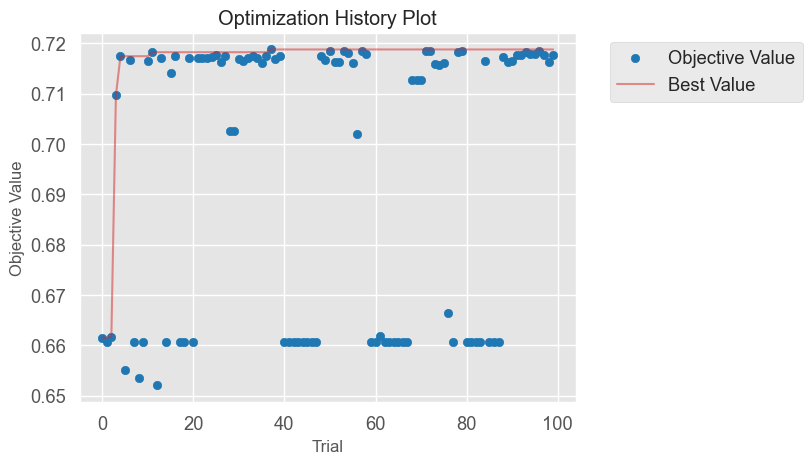

In [30]:
optuna.visualization.matplotlib.plot_optimization_history(study_lr)

In [31]:
# Printing the best parameter outcomes
params_lr = study_lr.best_params
print(params_lr)

{'solver_penalty': ('lbfgs', 'l2'), 'C': 0.1629728275553265, 'tol': 0.0011188549894785617, 'verbose': 0}


In [32]:
# Listing the best parameters for modeling
final_params_lr = study_lr.best_trial.params.copy()

In [33]:
# Separating solver and penalty
solver, penalty = final_params_lr.pop('solver_penalty')

# Add them separately
final_params_lr['solver'] = solver
final_params_lr['penalty'] = penalty

In [34]:
# Instantiating the classifier 
model_lr_tuned = LogisticRegression(**final_params_lr, random_state=123)

# Fitting the model
model_lr_tuned.fit(X_train_GA_full, y_train_full)

LogisticRegression(C=0.1629728275553265, random_state=123,
                   tol=0.0011188549894785617)

In [35]:
# Making predictions (test set)
y_pred_lr_tuned = model_lr_tuned.predict(X_test_GA)
y_proba_lr_tuned = model_lr_tuned.predict_proba(X_test_GA)
y_proba_lr_tuned_pos = y_proba_lr_tuned[:, 1]

In [36]:
# Making predictions (train set)
y_pred_lr_tuned_train = model_lr_tuned.predict(X_train_GA_full)
y_proba_lr_tuned_train = model_lr_tuned.predict_proba(X_train_GA_full)
y_proba_lr_tuned_train_pos = y_proba_lr_tuned_train[:, 1]

#### Evaluating logistic regression

In [37]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_lr_tuned, y_proba_lr_tuned_pos, "logistic regression with GA feature selection (test set)")

Evaluation metrics for logistic regression with GA feature selection (test set):
Accuracy: 0.6470
Precision: 0.4152
Recall: 0.7606
F1 Score: 0.5372
AUC-ROC: 0.7390
Precision-Recall AUC: 0.4747


In [38]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_lr_tuned_train, y_proba_lr_tuned_train_pos, "logistic regression with GA feature selection (train set)")

Evaluation metrics for logistic regression with GA feature selection (train set):
Accuracy: 0.6852
Precision: 0.6580
Recall: 0.7713
F1 Score: 0.7102
AUC-ROC: 0.7406
Precision-Recall AUC: 0.6985


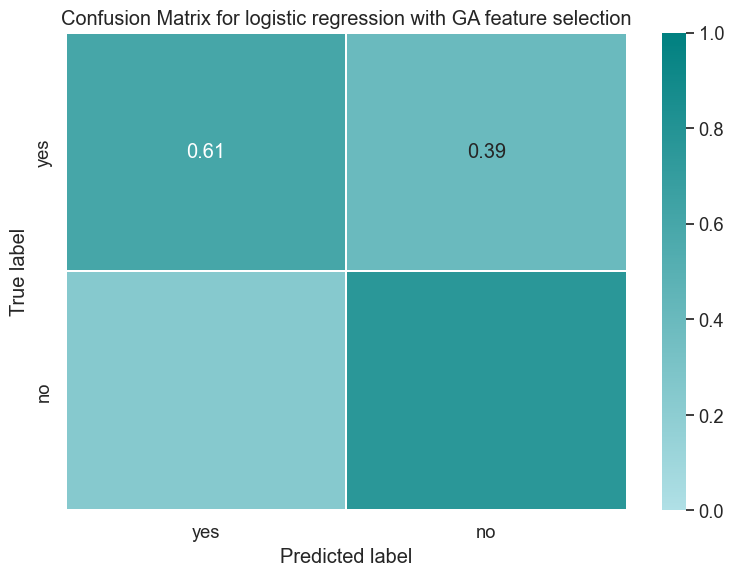

In [39]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_lr_tuned, "logistic regression with GA feature selection")

In [40]:
# Printing the classification report
print(classification_report(y_test, y_pred_lr_tuned, target_names = ['yes', 'no']))

              precision    recall  f1-score   support

         yes       0.87      0.61      0.71      5440
          no       0.42      0.76      0.54      2005

    accuracy                           0.65      7445
   macro avg       0.64      0.68      0.63      7445
weighted avg       0.75      0.65      0.67      7445



### Random forest

In [41]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67
# https://www.kaggle.com/code/mustafagerme/optimization-of-random-forest-model-using-optuna

# Define an objective function to be maximized using pre-defined train/val splits
def objective_rf(trial):
    # Defining the hyperparameters to be tuned
    n_estimators = trial.suggest_int("n_estimators", 100, 700, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt'])
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    # Defining model with trial hyperparameters
    params_rf = dict(max_depth=max_depth,
                     n_estimators=n_estimators,
                     max_features=max_features,
                     criterion=criterion,
                     min_samples_leaf=min_samples_leaf, 
                     min_samples_split=min_samples_split,
                     bootstrap=bootstrap
                     )
    model_rf = RandomForestClassifier(**params_rf, random_state=123, n_jobs=-1)
    
    # Fitting on training data
    model_rf.fit(X_train_GA, y_train)
    
    # Predicting and evaluating on validation data
    y_pred = model_rf.predict(X_val_GA)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_rf.trials))
print('Best parameters:', study_rf.best_trial.params)
print('Best F1 score:', study_rf.best_value)

[I 2025-05-16 19:07:12,321] A new study created in memory with name: no-name-230a290e-a04e-450f-be12-ee9a3eb5a0e3
[I 2025-05-16 19:08:04,266] Trial 1 finished with value: 0.7834744792858778 and parameters: {'n_estimators': 150, 'max_depth': 12, 'max_features': 'log2', 'criterion': 'gini', 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.7834744792858778.
[I 2025-05-16 19:08:39,250] Trial 3 finished with value: 0.7315741583257507 and parameters: {'n_estimators': 700, 'max_depth': 2, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.7834744792858778.
[I 2025-05-16 19:08:44,995] Trial 7 finished with value: 0.7442593426384512 and parameters: {'n_estimators': 650, 'max_depth': 3, 'max_features': 'sqrt', 'criterion': 'gini', 'min_samples_split': 6, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 1 with value: 0.7834744792858778.
[I 2025-0

Number of finished trials: 47
Best parameters: {'n_estimators': 650, 'max_depth': 15, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_samples_split': 8, 'min_samples_leaf': 10, 'bootstrap': False}
Best F1 score: 0.7859931113662457


/var/folders/sn/xsphv8q94nj2rnmccxb2nftm0000gn/T/ipykernel_9512/1451018526.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

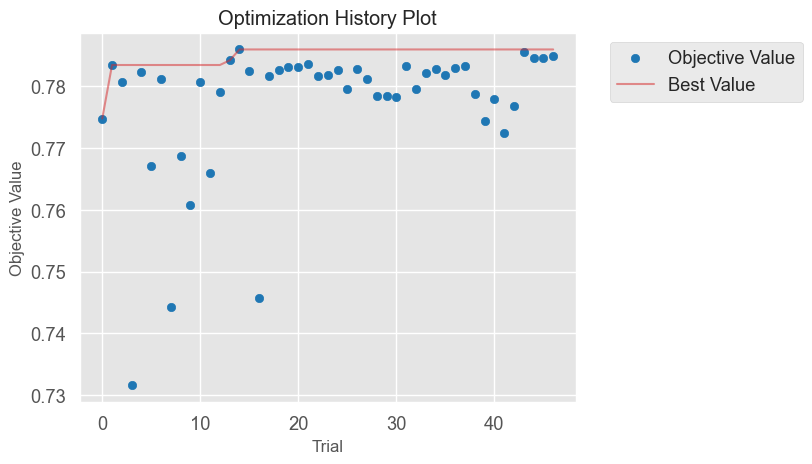

In [42]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

In [43]:
# Print the best parameter outcomes
params_rf = study_rf.best_params
print(params_rf)

{'n_estimators': 650, 'max_depth': 15, 'max_features': 'sqrt', 'criterion': 'entropy', 'min_samples_split': 8, 'min_samples_leaf': 10, 'bootstrap': False}


In [44]:
# List the best parameters for modeling
final_params_rf = dict(max_depth=params_rf['max_depth'],
                       n_estimators = params_rf['n_estimators'],
                       max_features = params_rf['max_features'],
                       criterion = params_rf['criterion'],
                       min_samples_leaf = params_rf['min_samples_leaf'],
                       min_samples_split = params_rf['min_samples_split'],
                       bootstrap = params_rf['bootstrap']
                       )

In [45]:
# Instantiating the classifier 
model_rf_tuned = RandomForestClassifier(**final_params_rf, random_state=123)

# Fitting the model
model_rf_tuned.fit(X_train_GA_full, y_train_full)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=15,
                       min_samples_leaf=10, min_samples_split=8,
                       n_estimators=650, random_state=123)

In [46]:
# Making predictions (test set)
y_pred_rf = model_rf_tuned.predict(X_test_GA)
y_proba_rf = model_rf_tuned.predict_proba(X_test_GA)
y_proba_rf_pos = y_proba_rf[:, 1]

In [47]:
# Making predictions (train set)
y_pred_rf_train = model_rf_tuned.predict(X_train_GA_full)
y_proba_rf_train = model_rf_tuned.predict_proba(X_train_GA_full)
y_proba_rf_train_pos = y_proba_rf_train[:, 1]

#### Evaluating random forest

In [48]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_rf, y_proba_rf_pos, "random forest with GA feature selection")

Evaluation metrics for random forest with GA feature selection:
Accuracy: 0.7649
Precision: 0.5476
Recall: 0.7322
F1 Score: 0.6265
AUC-ROC: 0.8332
Precision-Recall AUC: 0.6213


In [49]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_rf_train, y_proba_rf_train_pos, "random forest with GA feature selection (train set)")

Evaluation metrics for random forest with GA feature selection (train set):
Accuracy: 0.9169
Precision: 0.8974
Recall: 0.9414
F1 Score: 0.9189
AUC-ROC: 0.9793
Precision-Recall AUC: 0.9795


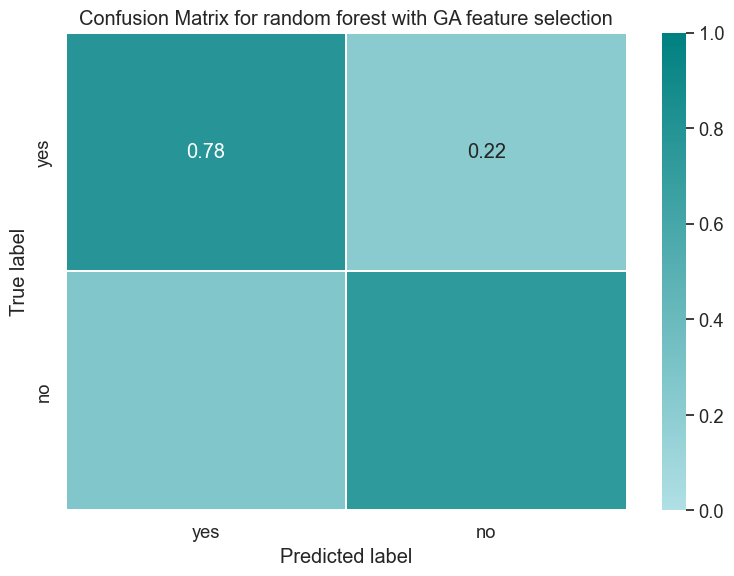

In [50]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, "random forest with GA feature selection")

In [51]:
# Printing the classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      5440
           1       0.55      0.73      0.63      2005

    accuracy                           0.76      7445
   macro avg       0.72      0.75      0.73      7445
weighted avg       0.80      0.76      0.77      7445



### XGBoost

In [52]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67
# https://www.kaggle.com/code/cahyaalkahfi/xgboost-model-tuning-using-optuna

# Defining an objective function to be maximized using pre-defined train/val splits
def objective_xgb(trial):
    # Defining the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0, 5)
    
    # Defining model with trial hyperparameters
    params_xgb = dict(n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree, 
                     min_child_weight=min_child_weight,
                     gamma=gamma
                     )
    model_xgb = XGBClassifier(**params_xgb, random_state=123, n_jobs=-1)
    
    # Fitting on training data
    model_xgb.fit(X_train_GA, y_train)
    
    # Predicting and evaluating on validation data
    y_pred = model_xgb.predict(X_val_GA)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_xgb.trials))
print('Best parameters:', study_xgb.best_trial.params)
print('Best F1 score:', study_xgb.best_value)

[I 2025-05-16 19:24:01,241] A new study created in memory with name: no-name-23fb8312-2406-4334-a8c8-501a2e3149bb
[I 2025-05-16 19:24:04,465] Trial 0 finished with value: 0.7821266968325792 and parameters: {'n_estimators': 58, 'max_depth': 3, 'learning_rate': 0.10244095766500104, 'subsample': 0.590501295752804, 'colsample_bytree': 0.9419198279902319, 'min_child_weight': 3, 'gamma': 2.5866798756083877}. Best is trial 0 with value: 0.7821266968325792.
[I 2025-05-16 19:24:05,617] Trial 2 finished with value: 0.7747564015409019 and parameters: {'n_estimators': 83, 'max_depth': 3, 'learning_rate': 0.05491302583777679, 'subsample': 0.7886423473566746, 'colsample_bytree': 0.759143110842577, 'min_child_weight': 7, 'gamma': 3.611142940497085}. Best is trial 0 with value: 0.7821266968325792.
[I 2025-05-16 19:24:07,737] Trial 5 finished with value: 0.8059023836549376 and parameters: {'n_estimators': 117, 'max_depth': 4, 'learning_rate': 0.06529336083285676, 'subsample': 0.6216162741613336, 'colsa

Number of finished trials: 100
Best parameters: {'n_estimators': 255, 'max_depth': 3, 'learning_rate': 0.16029955869462456, 'subsample': 0.9441970323533588, 'colsample_bytree': 0.853146200111162, 'min_child_weight': 5, 'gamma': 0.8388166133753827}
Best F1 score: 0.837225595516114


/var/folders/sn/xsphv8q94nj2rnmccxb2nftm0000gn/T/ipykernel_9512/1860755764.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_xgb)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

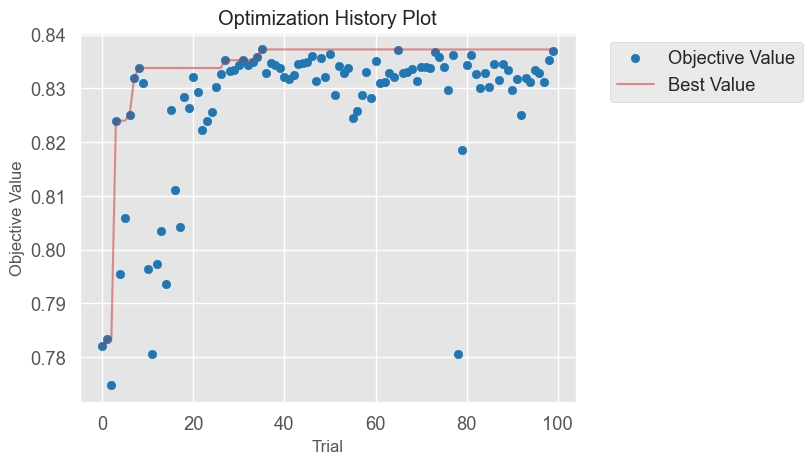

In [53]:
optuna.visualization.matplotlib.plot_optimization_history(study_xgb)

In [54]:
# Print the best parameter outcomes
params_xgb = study_xgb.best_params
print(params_xgb)

{'n_estimators': 255, 'max_depth': 3, 'learning_rate': 0.16029955869462456, 'subsample': 0.9441970323533588, 'colsample_bytree': 0.853146200111162, 'min_child_weight': 5, 'gamma': 0.8388166133753827}


In [55]:
# List the best parameters for modeling
final_params_xgb = dict(max_depth=params_xgb['max_depth'],
                       learning_rate=params_xgb['learning_rate'],
                       n_estimators=params_xgb['n_estimators'],
                       subsample=params_xgb['subsample'],
                       colsample_bytree=params_xgb['colsample_bytree'],
                       min_child_weight=params_xgb['min_child_weight'],
                       gamma=params_xgb['gamma']
                       )

In [56]:
# Instantiating the classifier 
model_xgb_tuned = XGBClassifier(**final_params_xgb, random_state=123)

# Fit the model
model_xgb_tuned.fit(X_train_GA_full, y_train_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.853146200111162, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.8388166133753827, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16029955869462456,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=255, n_jobs=None,
              num_parallel_tree=None, ...)

In [57]:
# Making predictions (test set)
y_pred_xgb = model_xgb_tuned.predict(X_test_GA)
y_proba_xgb = model_xgb_tuned.predict_proba(X_test_GA)
y_proba_xgb_pos = y_proba_xgb[:, 1]

In [58]:
# Making predictions (train set)
y_pred_xgb_train = model_xgb_tuned.predict(X_train_GA_full)
y_proba_xgb_train = model_xgb_tuned.predict_proba(X_train_GA_full)
y_proba_xgb_train_pos = y_proba_xgb_train[:, 1]

#### Evaluating XGBoost

In [59]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_xgb, y_proba_xgb_pos, "XGBoost with GA feature selection")

Evaluation metrics for XGBoost with GA feature selection:
Accuracy: 0.7867
Precision: 0.6017
Recall: 0.6155
F1 Score: 0.6085
AUC-ROC: 0.8334
Precision-Recall AUC: 0.6293


In [60]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_xgb_train, y_proba_xgb_train_pos, "XGBoost with GA feature selection (train set)")

Evaluation metrics for XGBoost with GA feature selection (train set):
Accuracy: 0.8543
Precision: 0.8631
Recall: 0.8422
F1 Score: 0.8525
AUC-ROC: 0.9379
Precision-Recall AUC: 0.9455


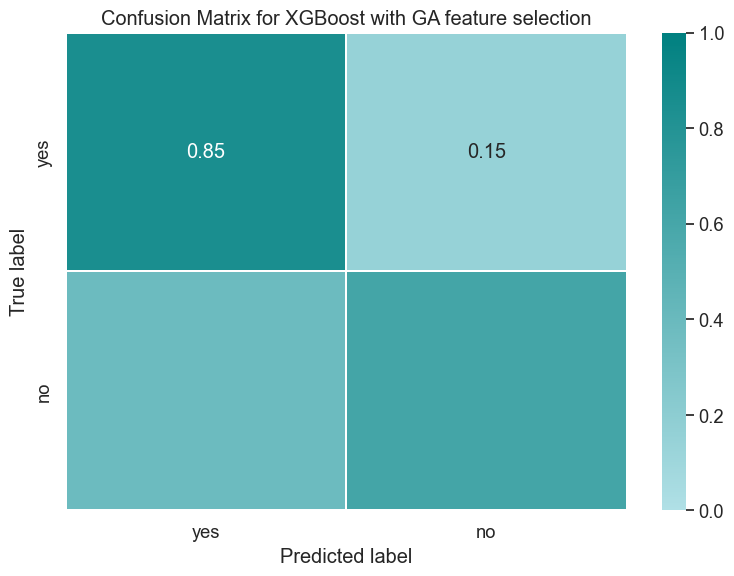

In [61]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost with GA feature selection")

In [62]:
# Printing the classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      5440
           1       0.60      0.62      0.61      2005

    accuracy                           0.79      7445
   macro avg       0.73      0.73      0.73      7445
weighted avg       0.79      0.79      0.79      7445



## SHAP

In [63]:
!pip install shap

In [64]:
import shap

In [65]:
feature_names = X_train_GA_full.columns.tolist()

In [66]:
X_train_GA_full = X_train_GA_full.values.astype(float)

In [67]:
X_train_GA_full = pd.DataFrame(X_train_GA_full, columns=feature_names)

### Baseline logistic regression SHAP analysis

In [68]:
# Code inspired by:
# https://github.com/jw-uvt/master-s-thesis-DS-S
# Calculating SHAP values
explainer_baseline_LR = shap.LinearExplainer(model_lr, X_train_GA_full)
shap_values_baseline_LR = explainer_baseline_LR(X_train_GA_full)

In [69]:
# Confirming shapes match before plotting
print("shap_values_LR shape:", shap_values_baseline_LR.shape)
print("X_train_GA_full shape:", X_train_GA_full.shape)

shap_values_LR shape: (43522, 37)
X_train_GA_full shape: (43522, 37)


In [70]:
# Ensuring that column names are included
shap_values_baseline_LR_expl = shap.Explanation(
    values=shap_values_baseline_LR,
    base_values=explainer_baseline_LR.expected_value,
    data=X_train_GA_full,
    feature_names=X_train_GA_full.columns.tolist()
)

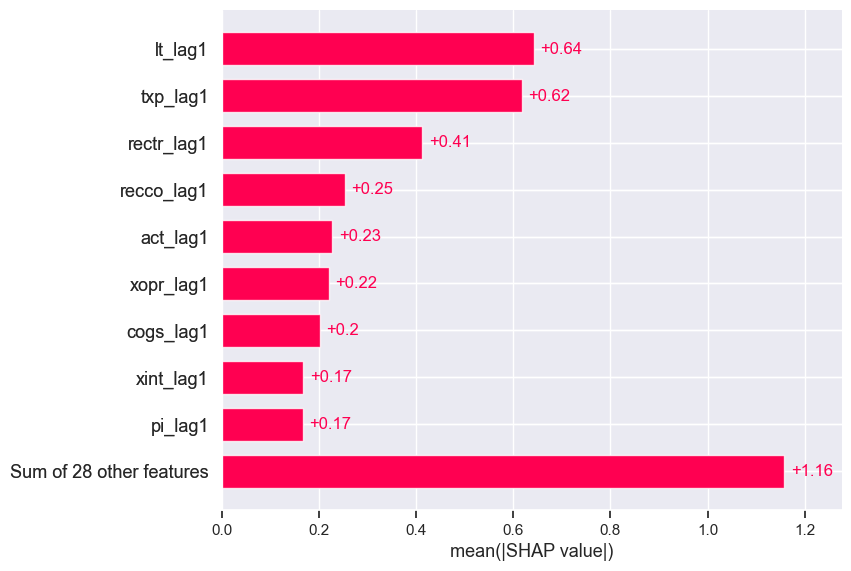

In [71]:
shap.plots.bar(shap_values_baseline_LR_expl)

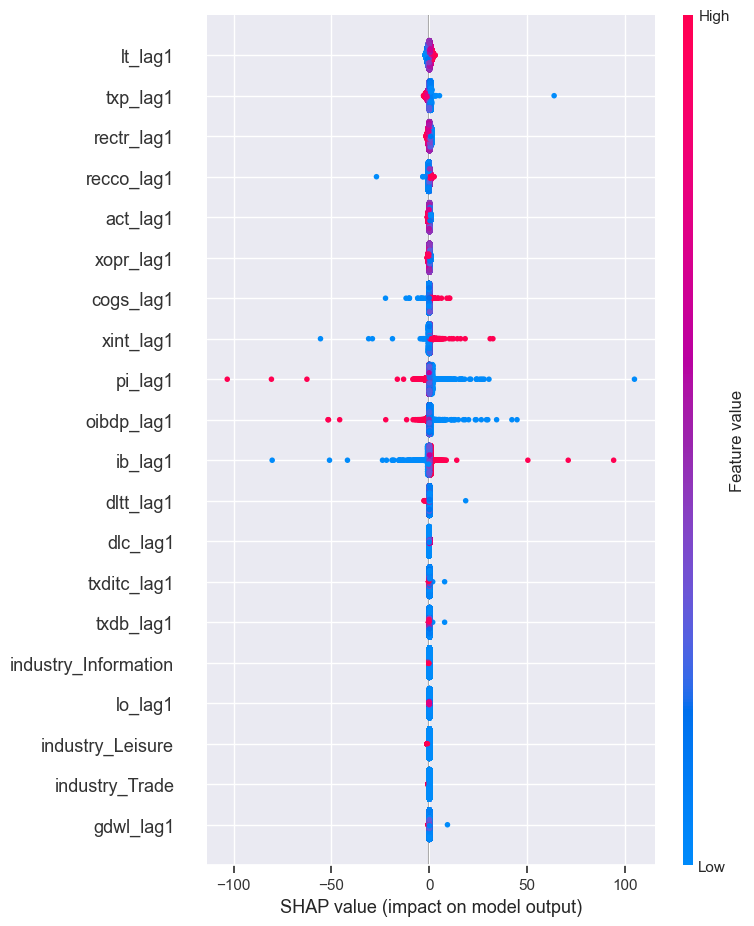

In [72]:
shap_values_baseline_LR_expl = shap_values_baseline_LR_expl.values.astype(float)
shap.summary_plot(shap_values_baseline_LR_expl, X_train_GA_full, max_display=20)

In [73]:
# Calculating absolute SHAP values
abs_shap_values_LR = np.abs(shap_values_baseline_LR_expl)

# Summing for each feature across all samples
overall_shap_values_baseline_LR = np.sum(shap_values_baseline_LR_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_baseline_LR = np.argsort(overall_shap_values_baseline_LR)[::-1]
sorted_features_baseline_LR = [feature_names[i] for i in sorted_features_indices_baseline_LR]

for feature_LR, shap_value_LR in zip(sorted_features_baseline_LR, overall_shap_values_baseline_LR[sorted_features_indices_baseline_LR]):
    print(f"Feature: {feature_LR}, Overall SHAP Value: {shap_value_LR}")

Feature: txp_lag1, Overall SHAP Value: 2169.0898111193414
Feature: rectr_lag1, Overall SHAP Value: 1664.0149936350504
Feature: xint_lag1, Overall SHAP Value: 1560.3812064381018
Feature: act_lag1, Overall SHAP Value: 774.7123457909964
Feature: xopr_lag1, Overall SHAP Value: 469.0213261690811
Feature: dlc_lag1, Overall SHAP Value: 347.69127596307004
Feature: industry_Leisure, Overall SHAP Value: 229.43287970622052
Feature: capx_lag1, Overall SHAP Value: 151.31251884360145
Feature: txdb_lag1, Overall SHAP Value: 124.5012264162265
Feature: txditc_lag1, Overall SHAP Value: 124.50122641619483
Feature: at_lag1, Overall SHAP Value: 37.45343665410261
Feature: apo_lag1, Overall SHAP Value: 17.02642900410229
Feature: pi_lag1, Overall SHAP Value: 11.57688347192794
Feature: dp_lag1, Overall SHAP Value: 3.6798851846557974
Feature: fyear_sin, Overall SHAP Value: 3.2069971871193426
Feature: fyear_cos, Overall SHAP Value: 0.0510509659346663
Feature: etr_lag1, Overall SHAP Value: -0.03751647341294185
Fe

In [74]:
total_features_baseline_LR = len(sorted_features_baseline_LR)

# Counting number of features with overall SHAP value of 0
zero_shap_count_baseline_LR = np.count_nonzero(overall_shap_values_baseline_LR == 0)

print(f"Total number of features: {total_features_baseline_LR}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_baseline_LR}")

Total number of features: 37
Number of features with overall SHAP value of 0: 0


### Logistic regression SHAP analysis

In [75]:
# Calculating SHAP values
explainer_LR = shap.LinearExplainer(model_lr_tuned, X_train_GA_full)
shap_values_LR = explainer_LR(X_train_GA_full)

In [76]:
# Confirming shapes match before plotting
print("shap_values_LR shape:", shap_values_LR.shape)
print("X_train_GA_full shape:", X_train_GA_full.shape)

shap_values_LR shape: (43522, 37)
X_train_GA_full shape: (43522, 37)


In [77]:
# Ensuring that column names are included
shap_values_LR_expl = shap.Explanation(
    values=shap_values_LR,
    base_values=explainer_LR.expected_value,
    data=X_train_GA_full,
    feature_names=X_train_GA_full.columns.tolist()
)

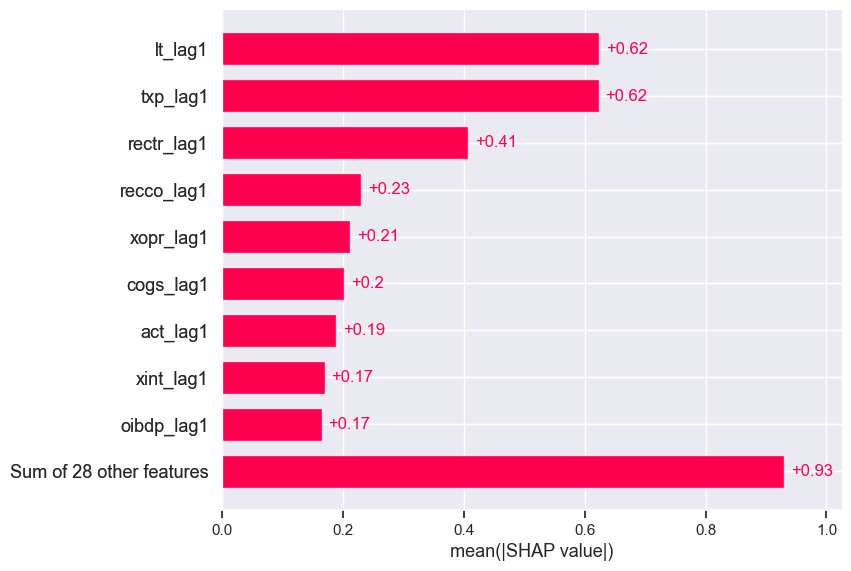

In [78]:
shap.plots.bar(shap_values_LR_expl)

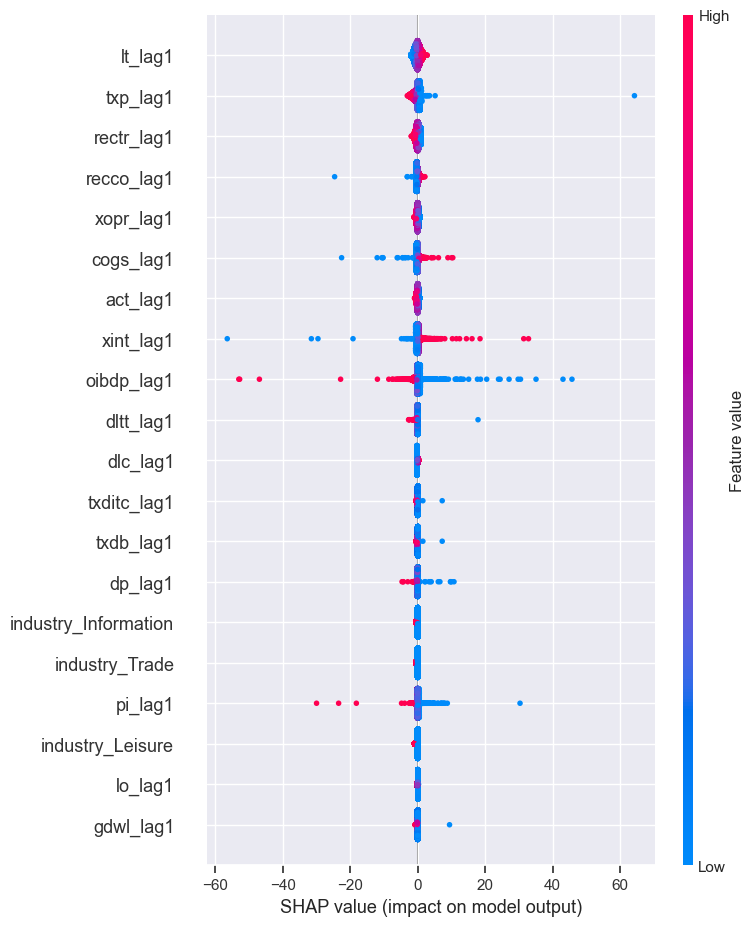

In [79]:
shap_values_LR_expl = shap_values_LR_expl.values.astype(float)
shap.summary_plot(shap_values_LR_expl, X_train_GA_full, max_display=20)

In [80]:
# Calculating absolute SHAP values
abs_shap_values_LR = np.abs(shap_values_LR_expl)

# Summing for each feature across all samples
overall_shap_values_LR = np.sum(shap_values_LR_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_LR = np.argsort(overall_shap_values_LR)[::-1]
sorted_features_LR = [feature_names[i] for i in sorted_features_indices_LR]

for feature_LR, shap_value_LR in zip(sorted_features_LR, overall_shap_values_LR[sorted_features_indices_LR]):
    print(f"Feature: {feature_LR}, Overall SHAP Value: {shap_value_LR}")

Feature: txp_lag1, Overall SHAP Value: 2188.964273862244
Feature: rectr_lag1, Overall SHAP Value: 1644.3615421559862
Feature: xint_lag1, Overall SHAP Value: 1582.2393641224062
Feature: act_lag1, Overall SHAP Value: 644.0788592003463
Feature: xopr_lag1, Overall SHAP Value: 451.8492382086236
Feature: dlc_lag1, Overall SHAP Value: 340.02826043715464
Feature: industry_Leisure, Overall SHAP Value: 195.61996207145378
Feature: capx_lag1, Overall SHAP Value: 149.1120586898941
Feature: txdb_lag1, Overall SHAP Value: 117.06415617396242
Feature: txditc_lag1, Overall SHAP Value: 117.06415617395962
Feature: at_lag1, Overall SHAP Value: 45.210231464602174
Feature: apo_lag1, Overall SHAP Value: 24.82778813925332
Feature: dp_lag1, Overall SHAP Value: 7.913232559937695
Feature: pi_lag1, Overall SHAP Value: 3.3571205774081365
Feature: fyear_sin, Overall SHAP Value: 0.19776130568269754
Feature: fyear_cos, Overall SHAP Value: 0.050188242692687984
Feature: etr_lag1, Overall SHAP Value: -0.23711059831995848

In [81]:
total_features_LR = len(sorted_features_LR)

# Counting number of features with overall SHAP value of 0
zero_shap_count_LR = np.count_nonzero(overall_shap_values_LR == 0)

print(f"Total number of features: {total_features_LR}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_LR}")

Total number of features: 37
Number of features with overall SHAP value of 0: 0


### Random forest SHAP analysis

In [82]:
# Calculating SHAP values
explainer_RF = shap.TreeExplainer(model_rf_tuned, X_train_GA_full)
shap_values_RF = explainer_RF(X_train_GA_full, approximate=True)

#### Class 1 (Tax Avoidance)

In [83]:
# Ensuring that column names are included
shap_values_RF_class_1 = shap_values_RF[:, :, 1]
shap_values_RF_expl_1 = shap.Explanation(
    values=shap_values_RF_class_1,
    base_values=explainer_RF.expected_value[1],
    data=X_train_GA_full,
    feature_names=X_train_GA_full.columns.tolist()
)

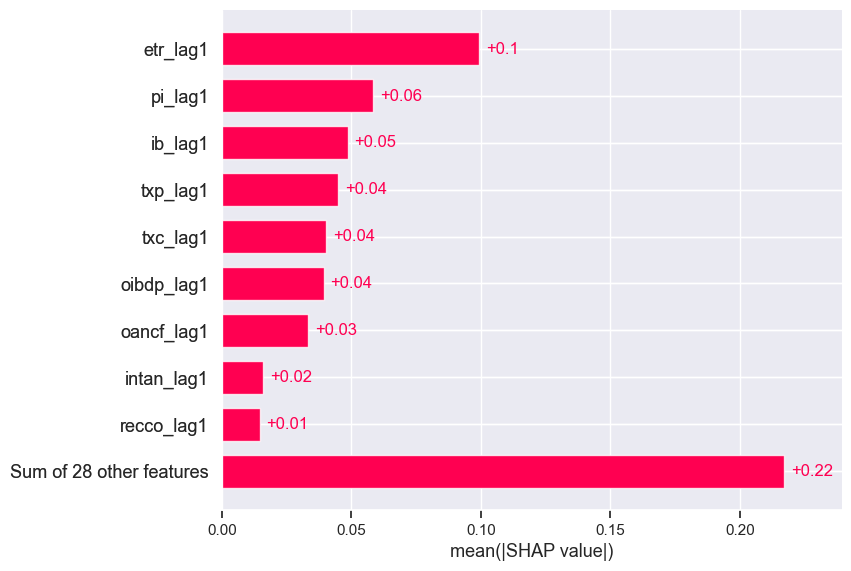

In [84]:
shap.plots.bar(shap_values_RF_expl_1)

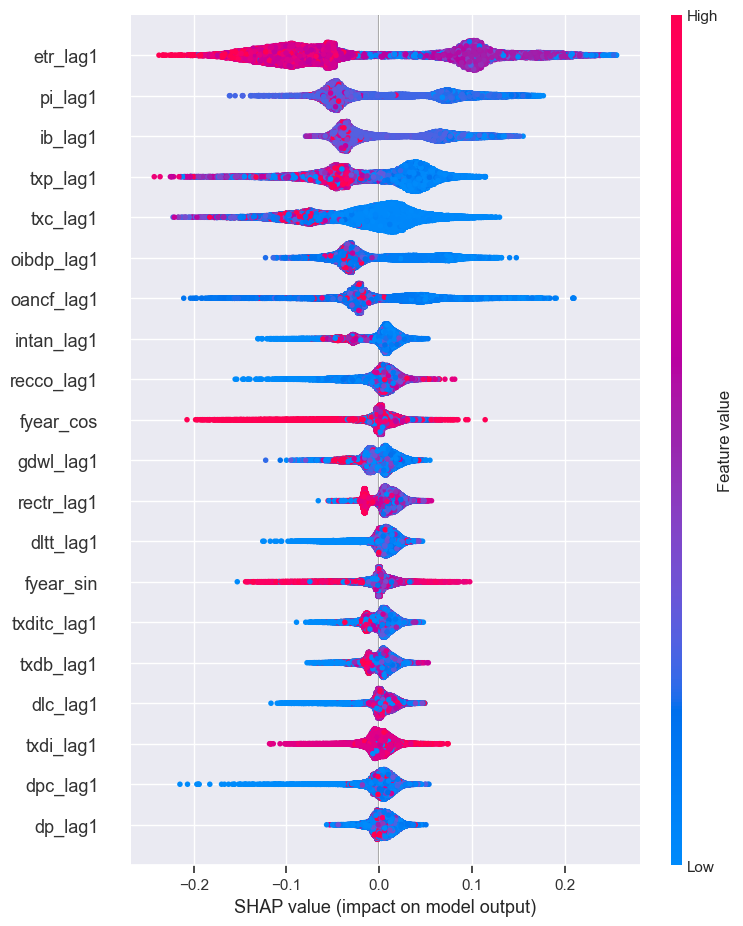

In [85]:
shap_values_RF_array_1 = shap_values_RF_class_1.values.astype(float)
shap.summary_plot(shap_values_RF_array_1, X_train_GA_full, max_display=20)

In [86]:
# Absolute SHAP values
abs_shap_values_RF_1 = np.abs(shap_values_RF_array_1)

# Overall importance per feature
overall_shap_values_RF_1 = np.sum(abs_shap_values_RF_1, axis=0)

# Sorting features by importance
feature_names = X_train_GA_full.columns.tolist()
sorted_indices_RF_1 = np.argsort(overall_shap_values_RF_1)[::-1]
sorted_features_RF_1 = [feature_names[i] for i in sorted_indices_RF_1]

# Displaying sorted feature importance
for feature, value in zip(sorted_features_RF_1, overall_shap_values_RF_1[sorted_indices_RF_1]):
    print(f"Feature: {feature}, Overall SHAP Value: {value}")

# Summary stats
total_features_RF_1 = len(sorted_features_RF_1)
zero_shap_count_RF_1 = np.count_nonzero(overall_shap_values_RF_1 == 0)

print(f"Total number of features: {total_features_RF_1}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_RF_1}")

Feature: etr_lag1, Overall SHAP Value: 4328.042415491023
Feature: pi_lag1, Overall SHAP Value: 2544.710757502656
Feature: ib_lag1, Overall SHAP Value: 2117.706410036395
Feature: txp_lag1, Overall SHAP Value: 1957.9860580183597
Feature: txc_lag1, Overall SHAP Value: 1754.6095740804124
Feature: oibdp_lag1, Overall SHAP Value: 1713.3179519735836
Feature: oancf_lag1, Overall SHAP Value: 1454.5525631126513
Feature: intan_lag1, Overall SHAP Value: 696.2787538916704
Feature: recco_lag1, Overall SHAP Value: 639.7034825675019
Feature: fyear_cos, Overall SHAP Value: 621.7823403883473
Feature: gdwl_lag1, Overall SHAP Value: 574.3094514052299
Feature: rectr_lag1, Overall SHAP Value: 565.9401914568607
Feature: dltt_lag1, Overall SHAP Value: 547.7435580107386
Feature: fyear_sin, Overall SHAP Value: 536.3639538446323
Feature: txditc_lag1, Overall SHAP Value: 493.0556798696477
Feature: txdb_lag1, Overall SHAP Value: 479.6984443920108
Feature: dlc_lag1, Overall SHAP Value: 442.4762963926531
Feature: tx

#### Class 0: No Tax Avoidance

In [87]:
# Ensuring that column names are included
shap_values_RF_class_0 = shap_values_RF[:, :, 0]
shap_values_RF_expl_0 = shap.Explanation(
    values=shap_values_RF_class_0,
    base_values=explainer_RF.expected_value[0],
    data=X_train_GA_full.values,
    feature_names=X_train_GA_full.columns.tolist()
)

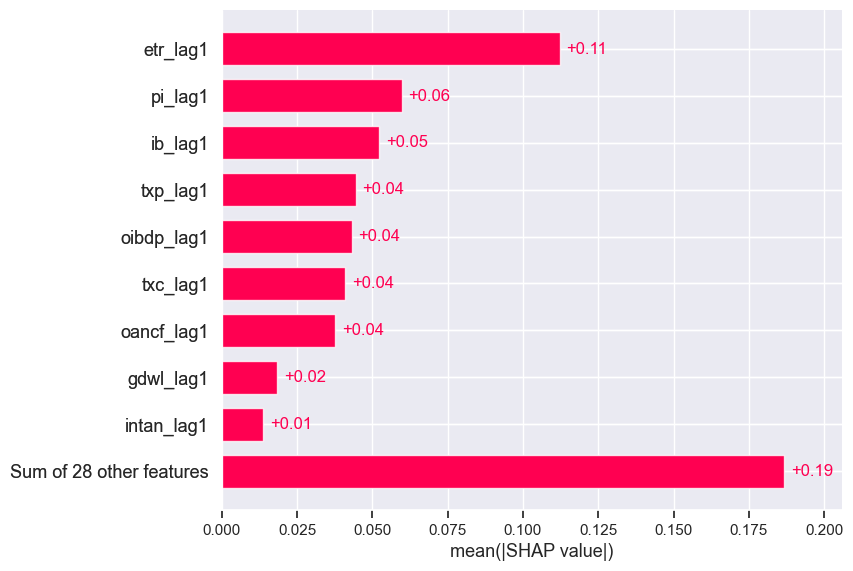

In [88]:
shap.plots.bar(shap_values_RF_expl_0)

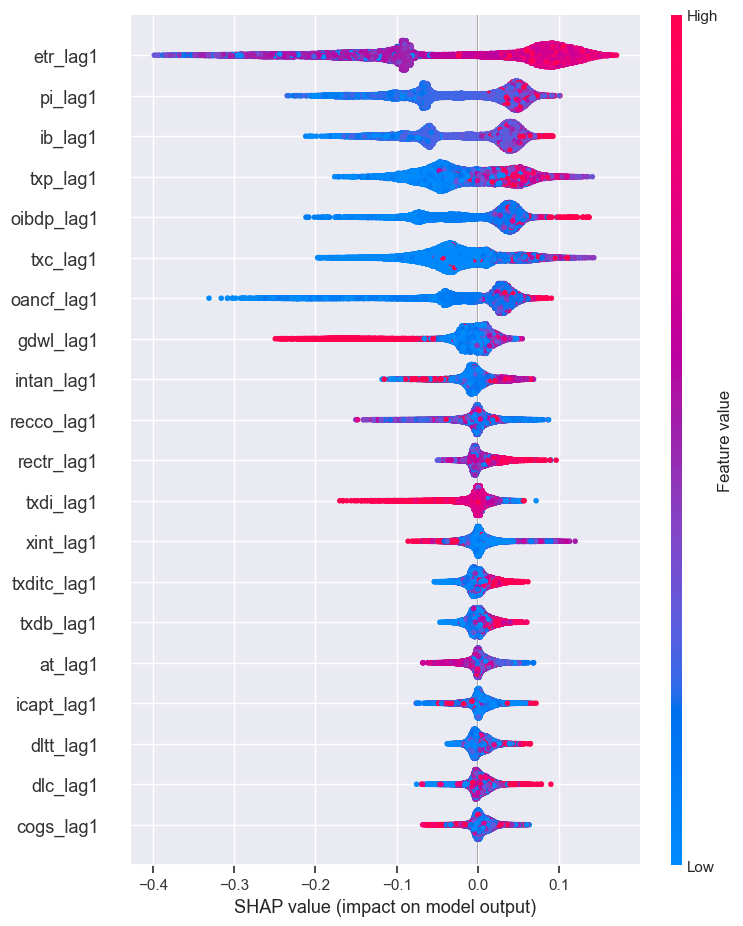

In [89]:
shap_values_RF_array_0 = shap_values_RF_class_0.values.astype(float)
shap.summary_plot(shap_values_RF_array_0, X_train_GA_full, max_display=20)

In [90]:
# Absolute SHAP values
abs_shap_values_RF_0 = np.abs(shap_values_RF_array_0)

# Overall importance per feature
overall_shap_values_RF_0 = np.sum(abs_shap_values_RF_0, axis=0)

# Sorting features by importance
feature_names = X_train_GA_full.columns.tolist()
sorted_indices_RF_0 = np.argsort(overall_shap_values_RF_0)[::-1]
sorted_features_RF_0 = [feature_names[i] for i in sorted_indices_RF_0]

# Displaying sorted feature importance
for feature, value in zip(sorted_features_RF_0, overall_shap_values_RF_0[sorted_indices_RF_0]):
    print(f"Feature: {feature}, Overall SHAP Value: {value}")

# Summary stats
total_features_RF_0 = len(sorted_features_RF_0)
zero_shap_count_RF_0 = np.count_nonzero(overall_shap_values_RF_0 == 0)

print(f"Total number of features: {total_features_RF_0}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_RF_0}")

Feature: etr_lag1, Overall SHAP Value: 4881.48386353558
Feature: pi_lag1, Overall SHAP Value: 2600.509580016347
Feature: ib_lag1, Overall SHAP Value: 2271.114271775956
Feature: txp_lag1, Overall SHAP Value: 1930.9757705039472
Feature: oibdp_lag1, Overall SHAP Value: 1878.6262237158667
Feature: txc_lag1, Overall SHAP Value: 1781.6265732818167
Feature: oancf_lag1, Overall SHAP Value: 1636.8509231331375
Feature: gdwl_lag1, Overall SHAP Value: 797.9081111758532
Feature: intan_lag1, Overall SHAP Value: 593.9777878448973
Feature: recco_lag1, Overall SHAP Value: 529.5838157504907
Feature: rectr_lag1, Overall SHAP Value: 476.0001148767213
Feature: txdi_lag1, Overall SHAP Value: 436.68965389766504
Feature: xint_lag1, Overall SHAP Value: 430.66497900963805
Feature: txditc_lag1, Overall SHAP Value: 419.3186202599724
Feature: txdb_lag1, Overall SHAP Value: 405.18634840432077
Feature: at_lag1, Overall SHAP Value: 383.92033952998656
Feature: icapt_lag1, Overall SHAP Value: 380.95576111515516
Feature

### XGBoost SHAP analysis

In [91]:
# Calculating SHAP values
explainer_XGB = shap.TreeExplainer(model_xgb_tuned, X_train_GA_full)
shap_values_XGB = explainer_XGB(X_train_GA_full)

 99%|===================| 43106/43522 [01:18<00:00]        

In [92]:
# Confirming shapes match before plotting
print("shap_values_XGB shape:", shap_values_XGB.shape)
print("X_train_GA_full shape:", X_train_GA_full.shape)

shap_values_XGB shape: (43522, 37)
X_train_GA_full shape: (43522, 37)


In [93]:
# Ensuring that column names are included
shap_values_XGB_expl = shap.Explanation(
    values=shap_values_XGB,
    base_values=explainer_XGB.expected_value,
    data=X_train_GA_full,
    feature_names=X_train_GA_full.columns.tolist()
)

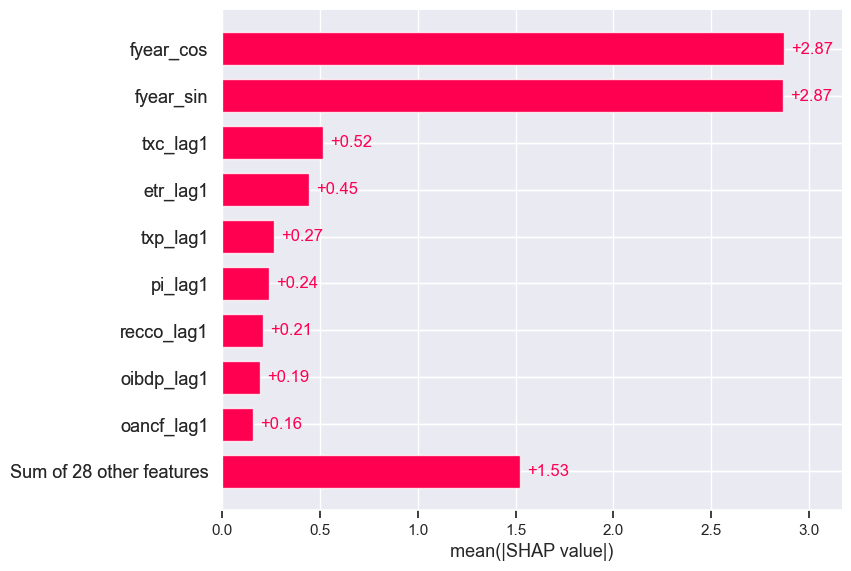

In [94]:
shap.plots.bar(shap_values_XGB_expl)

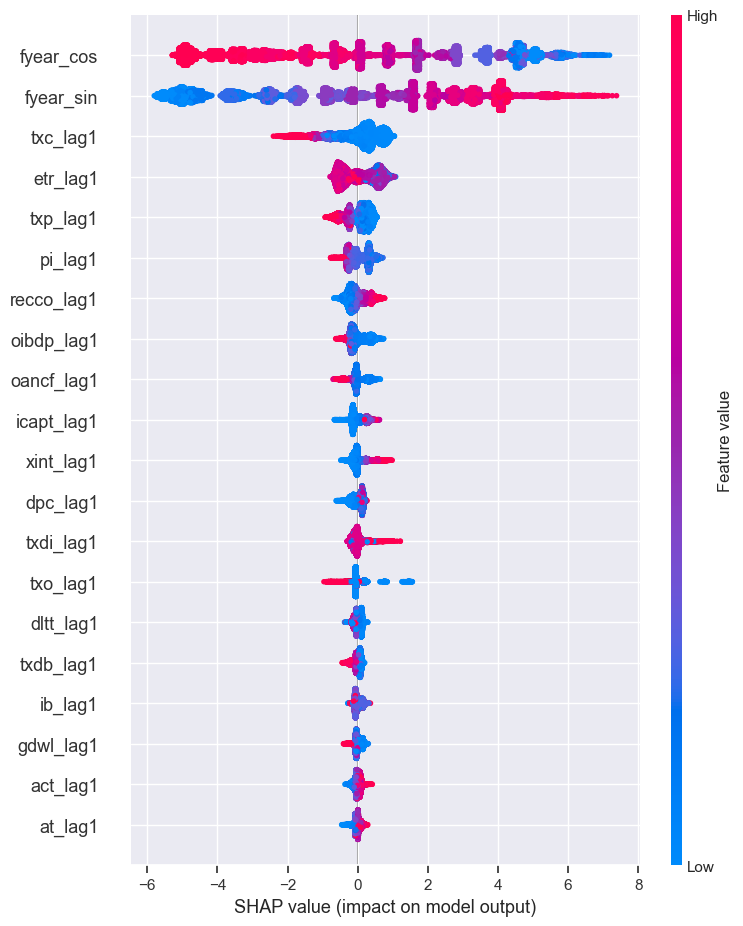

In [95]:
shap_values_XGB_expl = shap_values_XGB_expl.values.astype(float)
shap.summary_plot(shap_values_XGB_expl, X_train_GA_full, max_display=20)

In [96]:
# Calculating absolute SHAP values
abs_shap_values_XGB = np.abs(shap_values_XGB_expl)

# Summing for each feature across all samples
overall_shap_values_XGB = np.sum(shap_values_XGB_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_XGB = np.argsort(overall_shap_values_XGB)[::-1]
sorted_features_XGB = [feature_names[i] for i in sorted_features_indices_XGB]

for feature_XGB, shap_value_XGB in zip(sorted_features_XGB, overall_shap_values_XGB[sorted_features_indices_XGB]):
    print(f"Feature: {feature_XGB}, Overall SHAP Value: {shap_value_XGB}")

Feature: fyear_cos, Overall SHAP Value: 5053.686450000717
Feature: etr_lag1, Overall SHAP Value: 2226.1604124519845
Feature: pi_lag1, Overall SHAP Value: 1538.949735425984
Feature: txp_lag1, Overall SHAP Value: 1282.5863352924464
Feature: txc_lag1, Overall SHAP Value: 1142.9880602209612
Feature: xint_lag1, Overall SHAP Value: 1009.0826334100674
Feature: dltt_lag1, Overall SHAP Value: 697.9637623605006
Feature: oancf_lag1, Overall SHAP Value: 503.6298093473654
Feature: ib_lag1, Overall SHAP Value: 456.0511740866904
Feature: rectr_lag1, Overall SHAP Value: 405.8860736931834
Feature: gdwl_lag1, Overall SHAP Value: 325.9763175295033
Feature: xopr_lag1, Overall SHAP Value: 188.52811649506742
Feature: icapt_lag1, Overall SHAP Value: 179.40285850592696
Feature: industry_Leisure, Overall SHAP Value: 173.93464209345836
Feature: dp_lag1, Overall SHAP Value: 160.57390412333294
Feature: region_South, Overall SHAP Value: 157.2614013609428
Feature: intan_lag1, Overall SHAP Value: 127.79802741228104


In [97]:
total_features_XGB = len(sorted_features_XGB)

# Counting number of features with overall SHAP value of 0
zero_shap_count_XGB = np.count_nonzero(overall_shap_values_XGB == 0)

print(f"Total number of features: {total_features_XGB}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_XGB}")

Total number of features: 37
Number of features with overall SHAP value of 0: 1
